<a href="https://colab.research.google.com/github/OliviaXu312/ANLY590/blob/master/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets

tfkl = tfk.layers

# Q1 Autoencoder

## Load Data

In [3]:
data, info = tfds.load('cifar10', with_info=True)
print(info)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteZF5Z7R/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteZF5Z7R/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    

In [5]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])

ds_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
ds_test = data["test"].map(preprocess)

In [ ]:
#test_labels = tf.one_hot(test_labels.astype(np.int32), depth = 10)

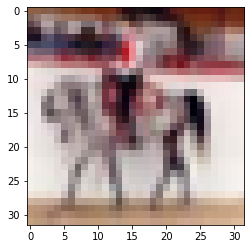

In [7]:
x, y = next(iter(ds_train))
plt.imshow(x[0,:,:,:])

## Convolutional Autoencoder Model

In [11]:
img_shape = info.features['image'].shape
img_shape

(32, 32, 3)

In [12]:
encoder = tfk.Sequential([
              tfkl.InputLayer(img_shape),
              tfkl.Conv2D(filters = 128, kernel_size=3, strides=1, 
                          padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2),
              tfkl.Dropout(0.2),

              tfkl.Conv2D(filters = 32, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2),
              tfkl.Dropout(0.2),

              tfkl.Conv2D(filters = 16, kernel_size=3, strides=1, 
                      padding="same", activation='relu'),
              tfkl.MaxPool2D(pool_size = 2)            
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4

In [13]:
decoder = tfk.Sequential([
              tfkl.InputLayer((4, 4, 16)),
              tfkl.Conv2D(filters = 16, kernel_size=3, strides=1, 
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 32, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 128, kernel_size=3, strides=1,
                      padding="same", activation='relu'),
              tfkl.UpSampling2D(size = 2),

              tfkl.Conv2D(filters = 3, kernel_size=3,
                           padding="same", activation='sigmoid')
              ])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 3)        

In [18]:
# the tf.keras function API starts with defining placeholder tensors that represent model inputs
x = tfkl.Input(img_shape)

# we can then pass this placeholder through our models to specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# finally we use the tfk.Model class instantiate the model by specifying the inputs and outputs
# (note: this can also be lists, which is how you make more complex models with multiple inputs and/or outputs)
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(ds_train, steps_per_epoch=100, epochs=10)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 4, 4, 16)          45104     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         47411     
Total params: 92,515
Trainable params: 92,515
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 38s 379ms/step - loss: 0.5952
Epoch 2/10
100/100 [==============================] - 38s 381ms/step - loss: 0.5881
Epoch 3/10
100/100 [==============================] - 39s 386ms/step - loss: 0.5852
Epoch 4/10
100/100 [==============================] - 38s 380ms/step - loss: 0.5814
Epoch 5/10
100/100 [========================

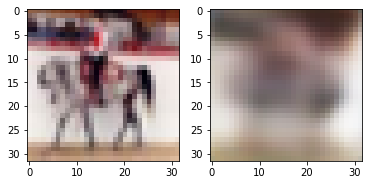

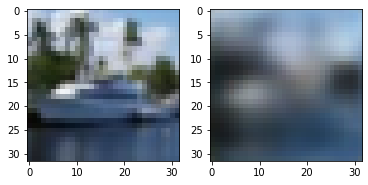

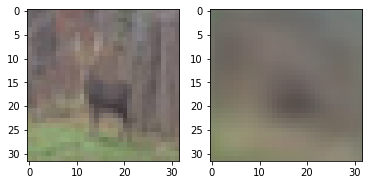

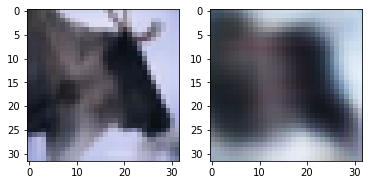

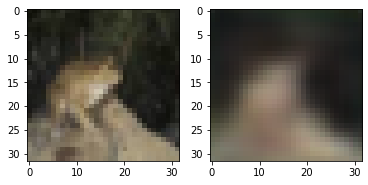

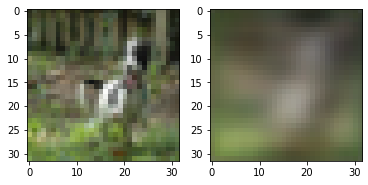

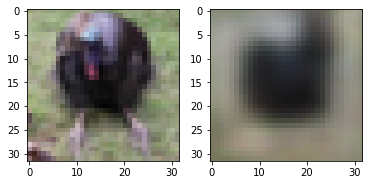

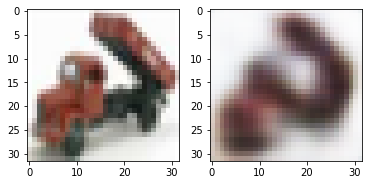

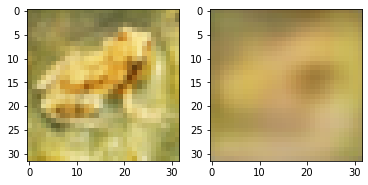

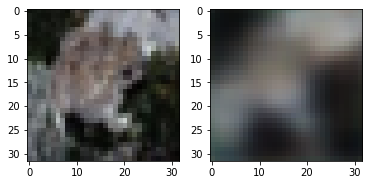

In [20]:
imgs = next(iter(ds_train))[0]
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

## Q2.1 Deep CNN

### Preprocessing data

In [22]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data['train'].map(preprocess).cache().batch(8)
ds_test = data["test"].map(preprocess).cache().batch(8)

### Deep CNN model

The structure I built for the deep CNN contains 12 layers. It stacks a convolution layer, follows them with a pooling layer and a dropout layer, and repeats this pattern three times while merging in 128 to 64 to 32 size. Then, I transited them into a fully-connected layers, and added another fully-connected layer. The last fully-connected layer holds the output for 10 classes. 

The kernel size I chosen is 3 and stride size is 1 to make sure the convolution layer does not alter the spatial dimensions of the input. 

And the padding method is same, which contains zero padding.

In [21]:
deep_cnn_model = tfk.Sequential()
deep_cnn_model.add(tfkl.Conv2D(filters = 128, kernel_size=3, strides=1, 
                      padding="same", activation='relu', input_shape=(32, 32, 3)))
deep_cnn_model.add(tfkl.MaxPool2D(pool_size = 2))
deep_cnn_model.add(tfkl.Dropout(0.2))

deep_cnn_model.add(tfkl.Conv2D(filters = 64, kernel_size=3, strides=1, 
                      padding="same", activation='relu'))
deep_cnn_model.add(tfkl.MaxPool2D(pool_size = 2))
deep_cnn_model.add(tfkl.Dropout(0.2))

deep_cnn_model.add(tfkl.Conv2D(filters = 32, kernel_size=3, strides=1, 
                      padding="same", activation='relu'))
deep_cnn_model.add(tfkl.MaxPool2D(pool_size = 2))
deep_cnn_model.add(tfkl.Dropout(0.2))

deep_cnn_model.add(tfkl.GlobalMaxPool2D())
deep_cnn_model.add(tfkl.Dense(64, activation='sigmoid'))
deep_cnn_model.add(tfkl.Dense(10, activation='softmax'))

deep_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)         

In [24]:
deep_cnn_model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

deep_cnn_results = deep_cnn_model.fit(ds_train, steps_per_epoch=100, epochs=20, validation_data = ds_test)

Epoch 1/20
100/100 [==============================] - 22s 217ms/step - loss: 2.3214 - val_loss: 2.3160
Epoch 2/20
100/100 [==============================] - 19s 185ms/step - loss: 2.2701 - val_loss: 2.2285
Epoch 3/20
100/100 [==============================] - 18s 184ms/step - loss: 2.1948 - val_loss: 2.1833
Epoch 4/20
100/100 [==============================] - 18s 180ms/step - loss: 2.0953 - val_loss: 2.1000
Epoch 5/20
100/100 [==============================] - 18s 180ms/step - loss: 2.0821 - val_loss: 2.0778
Epoch 6/20
100/100 [==============================] - 18s 180ms/step - loss: 2.0807 - val_loss: 2.0200
Epoch 7/20
100/100 [==============================] - 18s 179ms/step - loss: 2.0473 - val_loss: 2.0392
Epoch 8/20
100/100 [==============================] - 18s 180ms/step - loss: 2.0112 - val_loss: 1.9761
Epoch 9/20
100/100 [==============================] - 18s 180ms/step - loss: 1.9947 - val_loss: 2.1465
Epoch 10/20
100/100 [==============================] - 18s 181ms/step - l

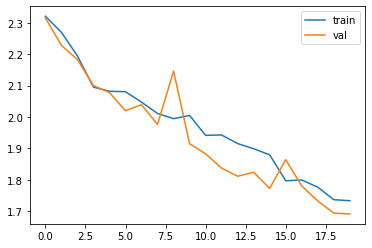

In [25]:
plt.plot(deep_cnn_results.history["loss"])
plt.plot(deep_cnn_results.history["val_loss"])
plt.legend(labels=["train", "val"])

# Q2.2 Transfer Learning

In [26]:
from tensorflow.keras.applications import VGG16

In [27]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

transfer_learning_model = tfk.Sequential()

transfer_learning_model.add(conv_base)
transfer_learning_model.add(tf.keras.layers.GlobalMaxPooling2D())
transfer_learning_model.add(tf.keras.layers.Dense(10, activation='softmax'))

transfer_learning_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transfer_learning_model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

transfer_learning_results = transfer_learning_model.fit(ds_train, steps_per_epoch=100, epochs=10, validation_data = ds_test)

Epoch 1/10
100/100 [==============================] - 205s 2s/step - loss: 90.4903 - val_loss: 2.3534
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 2.3671

In [ ]:
plt.plot(transfer_learning_results.history["loss"])
plt.plot(transfer_learning_results.history["val_loss"])
plt.legend(labels=["train", "val"])

# Q3. Text Classification

In [ ]:
df = pd.read_csv("SPAM_detection.csv")